# Fiddler Quickstart notebook for a Class Imbalance Example

Many ML use cases, like fraud detection and facial recognition, suffer from what is known as the class imbalance problem.  This problem exists where a vast majority of the inferences seen by the model belong to only one class, known as the majority class.  This makes detecting drift in the minority class very difficult as the "signal" is completely outweighed by the shear number of inferences seen in the majority class.  The following notebook showcases how Fiddler uses a class weighting paramater to deal with this problem. This notebook will onboard two identical models -- one without class imbalance weighting and one with class imbalance weighting -- to illustrate how drift signals in the minority class are easier to detect once properly amplified by Fiddler's unique class weighting approach.

1. Connect to Fiddler
2. Upload a baseline dataset for a fraud detection use case
3. Onboard two fraud models to Fiddler -- one with class weighting and one without
4. Publish production events to both models with synthetic drift in the minority class
5. Get Insights -- compare the two onboarding approaches in Fiddler

## 0. Imports

In [ ]:
!pip install -q fiddler-client;

import numpy as np
import pandas as pd
import fiddler as fdl
import sklearn
import datetime
import time

print(f"Running client version {fdl.__version__}")

RANDOM_STATE = 42

## 1. Connect to Fiddler

In [ ]:
URL = ''  # Make sure to include the full URL (including https://).
ORG_ID = ''
AUTH_TOKEN = ''

PROJECT_ID = 'imbalance_cc_fraud'
MODEL_ID = 'imbalance_cc_fraud'
DATASET_ID = 'imbalance_cc_fraud_baseline'

client = fdl.FiddlerApi(
    url=URL,
    org_id=ORG_ID,
    auth_token=AUTH_TOKEN
)

In [ ]:
# Create a new project within Fiddler
client.create_project(PROJECT_ID)

## 2. Upload a baseline dataset for a fraud detection use case


In [ ]:
PATH_TO_BASELINE_CSV = 'https://raw.githubusercontent.com/fiddler-labs/fiddler-examples/main/quickstart/data/imbalance_baseline_data_sample.csv'

baseline_df = pd.read_csv(PATH_TO_BASELINE_CSV)
baseline_df.head()

In [ ]:
baseline_df['Class'].value_counts()
print('Percentage of minority class: {}%'.format(round(baseline_df['Class'].value_counts()[1]*100/baseline_df.shape[0], 4)))

In [ ]:
dataset_info = fdl.DatasetInfo.from_dataframe(baseline_df, max_inferred_cardinality=100)
dataset_info

In [ ]:
client.upload_dataset(
    project_id=PROJECT_ID,
    dataset_id=DATASET_ID,
    dataset={
        'baseline': baseline_df
    },
    info=dataset_info
)

## 3. Onboard two fraud models to Fiddler -- one with class weighting and one without

Now, we will add two models: 
1. With class weight parameters
2. Without class weight parameters

In [ ]:
CLASS_WEIGHT = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(baseline_df['Class']), y=baseline_df['Class']).tolist()
print(f'Computed class-weights: {CLASS_WEIGHT}')

BINARY_THRESHOLD = 0.4
TARGET_COL = 'Class'
OUTPUT_COL = 'prediction_score'

Below, we first create a `ModelInfo` object and then onboard (add) the two models to Fiddler -- the first model onboarded with weights defined, the second without weights defined.

In [ ]:
for mid in [MODEL_ID + '_weighted', MODEL_ID]:
    
    if 'weighted' in mid:
        weighting_params = fdl.WeightingParams(class_weight=CLASS_WEIGHT)
        print(f'Onboard surrogate model with weighting parameters.')
    else:
        weighting_params = None
        print(f'Onboard surrogate model without weighting parameters.')
    
    target_col = TARGET_COL
    output_col = OUTPUT_COL
    inp_features = set(baseline_df.columns) - set([target_col, output_col])
    
    # Create ModelInfo object
    model_info = fdl.ModelInfo.from_dataset_info(
        dataset_info=dataset_info,
        target=target_col,
        dataset_id= DATASET_ID,
        features=inp_features,
        display_name='Fraud model',
        description='Fraud model with predictions in baseline',
        input_type=fdl.core_objects.ModelInputType.TABULAR,
        model_task=fdl.core_objects.ModelTask.BINARY_CLASSIFICATION,
        outputs=output_col,
        weighting_params=weighting_params,
        binary_classification_threshold=BINARY_THRESHOLD,
        categorical_target_class_details=[0, 1],
    )
    
    # Add Model and create surrogate model
    if mid not in client.list_models(project_id=PROJECT_ID):
        client.add_model(project_id=PROJECT_ID, model_id=mid, dataset_id=DATASET_ID, model_info=model_info)
        client.add_model_surrogate(project_id=PROJECT_ID, model_id=mid)
    else:
        print(f'Model: {mid} already exists in Project: {PROJECT_ID}')

## 4. Publish production events to both models with synthetic drift in the minority class

In [ ]:
PATH_TO_EVENTS_CSV = 'https://raw.githubusercontent.com/fiddler-labs/fiddler-examples/main/quickstart/data/imbalance_production_data.csv'

production_df = pd.read_csv(PATH_TO_EVENTS_CSV)

# Shift the timestamps of the production events to be as recent as today 
production_df['timestamp'] = pd.to_datetime(production_df['timestamp'],format='%Y-%m-%d %H:%M:%S')
production_df['timestamp'] = production_df['timestamp'] + (pd.to_datetime(datetime.date.today()) - (production_df['timestamp'].max()))

production_df.head()

In [ ]:
print('Percentage of minority class: {}%'.format(round(production_df['Class'].value_counts()[1]*100/production_df.shape[0], 4)))

We see that the percentage of minority class in production data is > 3 times than that of baseline data. This should create a big drift in the predictions.

We will now publish the same production/event data for both of the models -- the one with class weights and the one without class weights.

In [ ]:
for mid in [MODEL_ID + '_weighted', MODEL_ID]:
    t0 = time.time()
    print('Publishing events for Model ID: {}'.format(mid))
    client.publish_events_batch(
        project_id=PROJECT_ID,
        model_id=mid,
        batch_source=production_df,
        timestamp_field='timestamp'
    )
    t1 = time.time()
    dt = t1-t0
    print(f'Time required: {dt} secs for {len(production_df)} events. [{len(production_df)/dt} events/sec]')

## 5. Get Insights -- compare the two onboarding approaches in Fiddler

**You're all done!**


In the Fiddler UI, we can the model without the class weights defined the output/prediction drift in the minority class is very hard to detect (`<=0.05`) because it is trumped byt the overwhelming volume of events in the majority class.  If we declare class weights then we see a higher drift which is more correct respresentation if the production data where the ratio of minority is class is 3x.

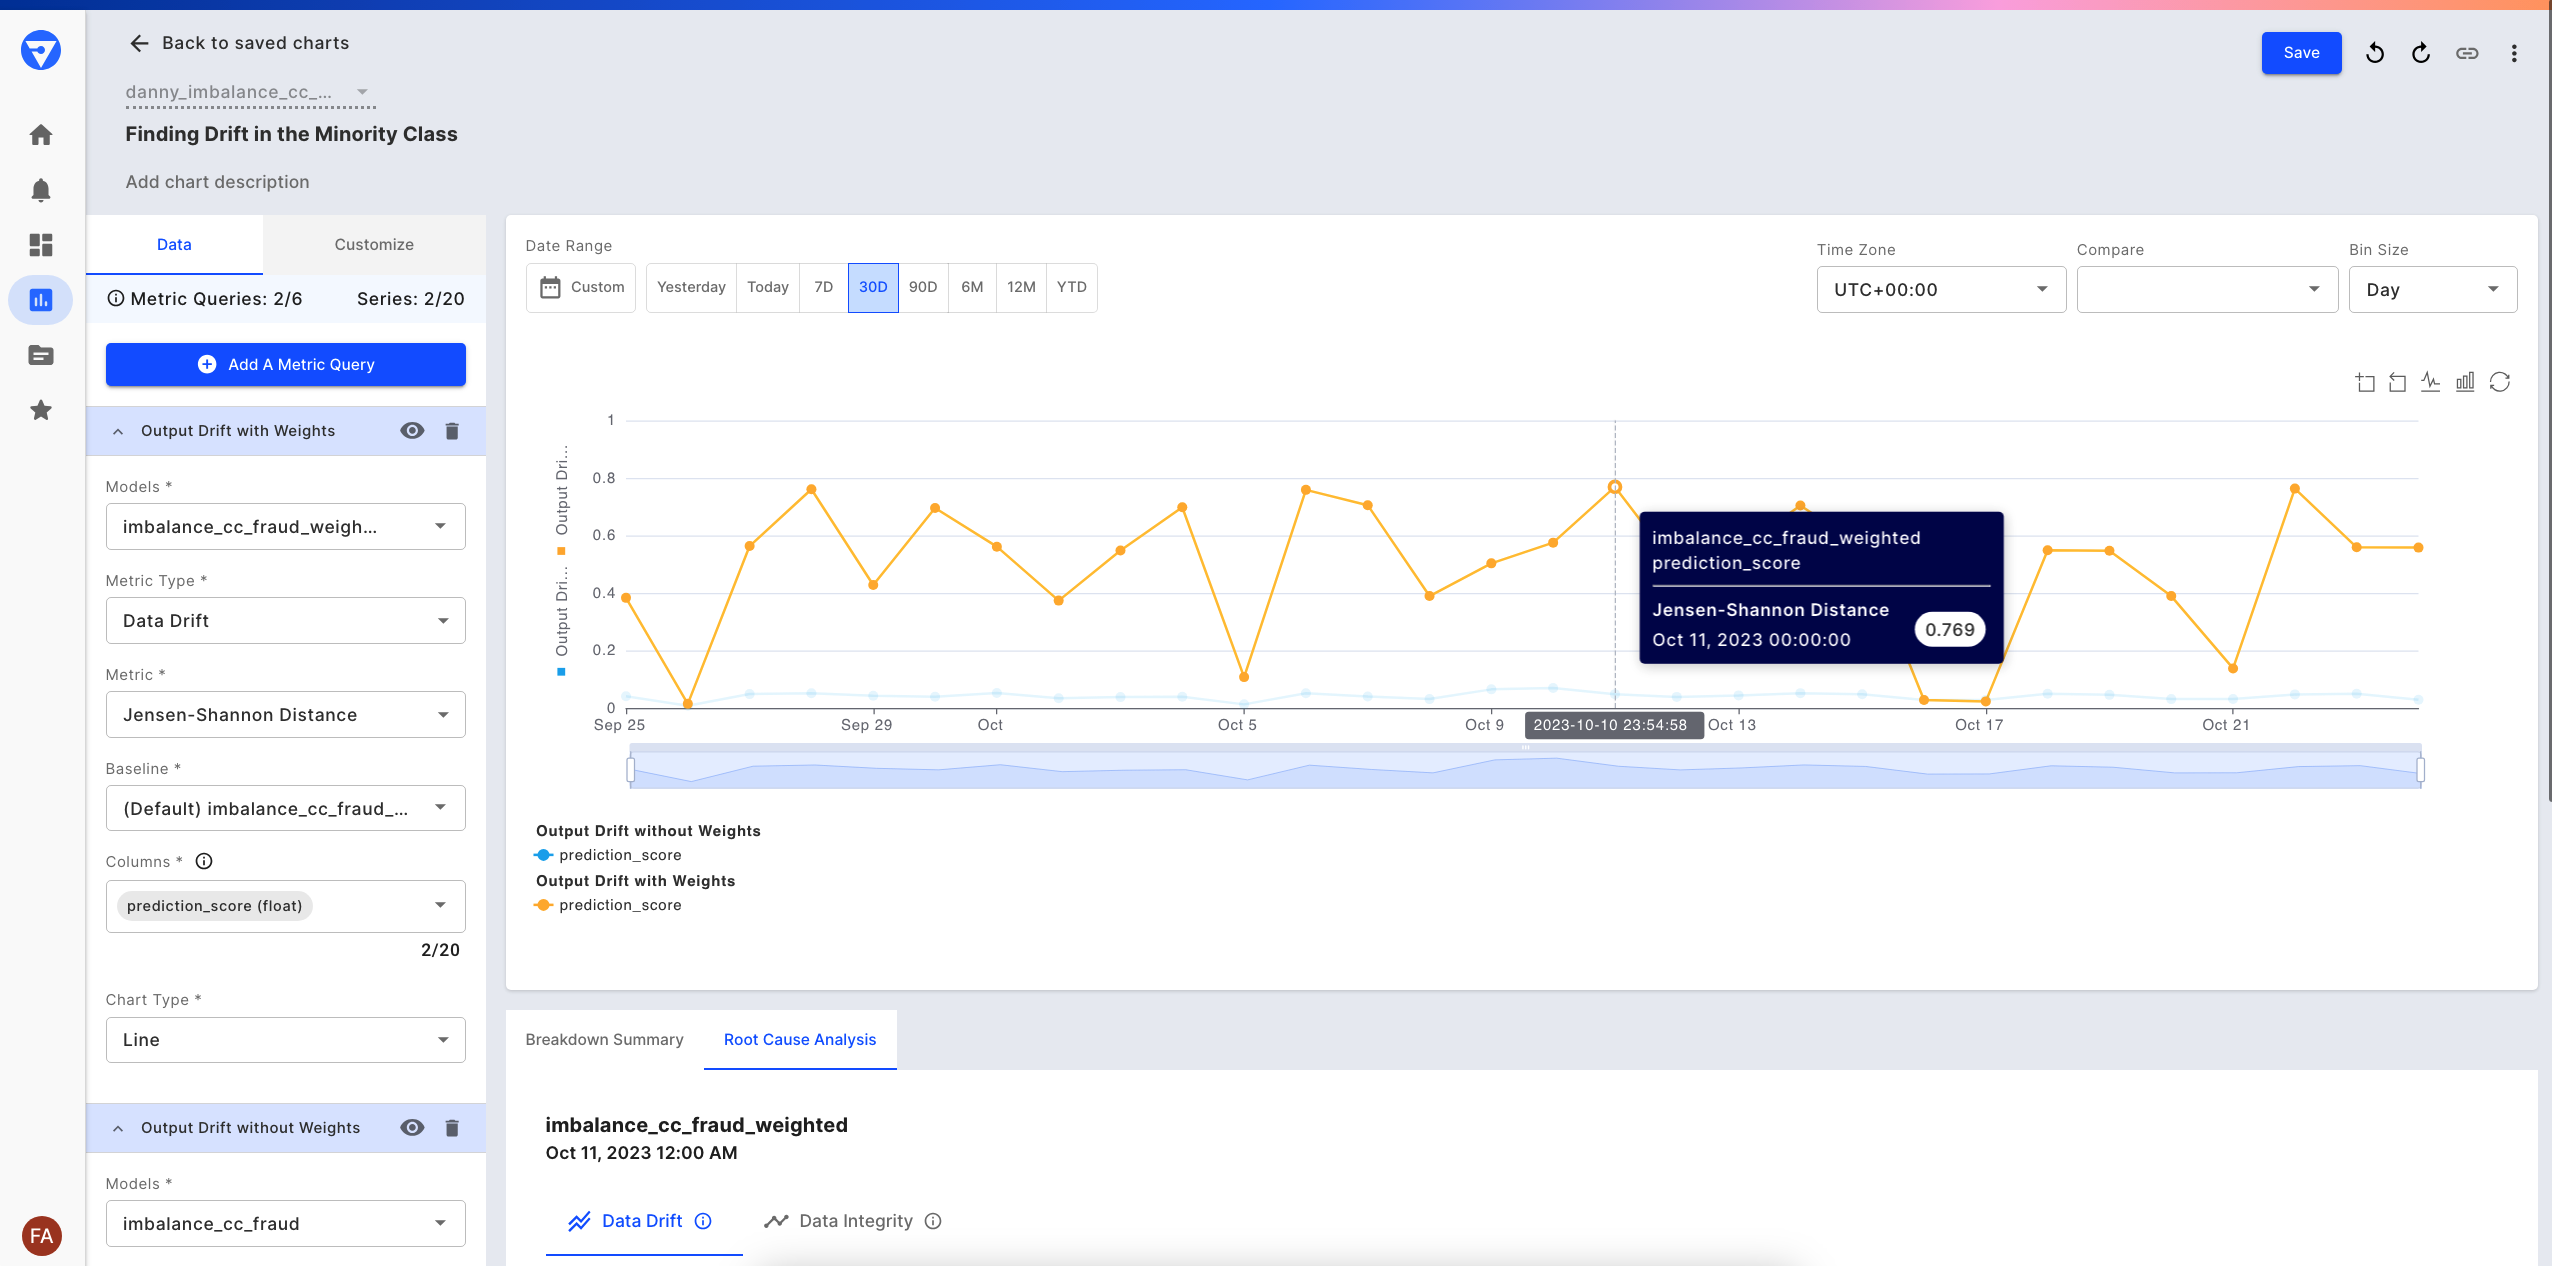



---


**Questions?**  
  
Check out [our docs](https://docs.fiddler.ai/) for a more detailed explanation of what Fiddler has to offer.

If you're still looking for answers, fill out a ticket on [our support page](https://fiddlerlabs.zendesk.com/) and we'll get back to you shortly.